In [1]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install --upgrade gensim

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu113.html
     |████████████████████████████████| 7.9 MB 2.8 MB/s 
     |████████████████████████████████| 3.5 MB 56.5 MB/s 
     |████████████████████████████████| 2.3 MB 44.5 MB/s 
     |████████████████████████████████| 747 kB 36.8 MB/s 
     |████████████████████████████████| 325 kB 5.0 MB/s 
     |████████████████████████████████| 407 kB 50.3 MB/s 
     |████████████████████████████████| 45 kB 657 kB/s 
  Created wheel for torch-geometric: filename=torch_geometric-2.0.2-py3-none-any.whl size=535570 sha256=a6a1361ee20ef6ec881d9616680280ab874d75144a96f0631f4b52f18722ea57
  Stored in directory: /root/.cache/pip/wheels/3f/08/13/2321517088bb2e95bfd0e45033bb9c923189e5b2078e0be4ef
Successfully built torch-geometric
     |████████████████████████████████| 24.1 MB 74.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# 第二课：网络嵌入

网络嵌入是一类学习图中的节点表示的方法。在理论课的学习中，我们引入了一个统一而通用的概括网络嵌入模型的框架，并基于该框架介绍了一些经典的网络嵌入的方法以及一些专门为异质图，二分图、多维图，符号图和超图等复杂图而设计的网络嵌入方法。这节实践课我们将对DeepWalk, Node2vec以及针对异质图的Metapath2Vec进行代码实践。

## 0. PyTorch Geometric 基础

PyTorch Geometric (PyG)是一个建立在PyTorch之上的库。利用PyG，我们可以轻松编写和训练图神经网络，并用于与结构化数据相关的应用。PyG支持许多与图数据相关的功能，比如异质图、点云、小批量加载器和各种常用基准数据集等等。

### 0.0 PyG的安装

现在PyG已经支持使用Anaconda安装，见官网https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html 。
我们也推荐使用Anaconda来安装PyG，会比pip安装更简单，且更不容易出错。
注意：正确选择对应的计算机系统、PyTorch版本和CUDA或者CPU版本。 （pytorch 1.8可能会更稳定）

`conda install pytorch=1.8 # pytorch 1.8可能会更稳定`

`conda install pyg -c pyg -c conda-forge` 

建议安装pyg最新版，即2.0.0版本，对异质图提供了更多支持。

### 0.1. 加载图数据

接下来我们以Cora数据集为例，来展示加载图数据的过程。

**Cora数据集**：Cora是一个引文网络，其中每个节点代表一篇论文，节点之间的边表示论文之间的引用关系。节点属性是关于论文的词袋（bag-of-words）描述。每个节点（论文）分为7类。

In [2]:
from torch_geometric.datasets import Planetoid
import networkx as nx
import torch_geometric
dataset = Planetoid(root='./data', name='Cora') # 将数据保存在data文件夹下

Processing...
Done!


加载出来的dataset是PyG里实现的一个类，这个类里包含了K张图（K的大小由数据集本身决定；对于Cora数据集，K的值为1）

In [3]:
dataset

Cora()

In [4]:
len(dataset) # dataset的长度是1， 故只包含一张图

1

In [5]:
# 我们可以通过下标来访问dataset里的每张图（注意Cora里只有一张图，所以我们用dataset[0]）
dataset[0]

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

对于上面的数据格式，我们可以看到，每张图其实是一个PyG定义的Data类。这个类里包含了该数据集的基本属性，比如边（edge_index）、节点特征（x）、节点标签（y）、测试集（test_mask）、训练集（train_mask）和验证集（val_mask）。由此可见，Cora有10556条边，2708个节点，节点特征的维度是1433。

值得注意的是：
1. 表示图结构的数据形式有很多种，最为常见的是邻接矩阵（adjacency matrix）。如果我们用A表示一个邻接矩阵，那么A[i,j] = 1就表示节点i和节点j之间存在一条边。若A[i,j] = 0就表示节点i和节点j之间不存在连接。因为图通常是稀疏的，所以我们经常用稀疏矩阵来存储这个邻接矩阵。
2. PyG中不是直接存储邻接矩阵，而是存储边的索引（edge_index ）和边权重（edge_weight）。其中edge_index的是一个大小为(2, |E|)的tensor（|E|是边的数量）。举个简单的例子，下面这个图中，节点1、2、3互相连接，那么图里面的边就有(1,2), (1,3), (2,3), (2,1), (3,1), (3,2)。那么edge_index就可以表示为[[1,1,2,2,3,3], [2,3,3,1,1,2]]。

![](figures/toy_graph.png)

我们还可以通过PyG提供的函数来把edge_index转换成稀疏矩阵，如下所示：

In [6]:
adj = torch_geometric.utils.to_scipy_sparse_matrix(dataset[0].edge_index)
adj

<2708x2708 sparse matrix of type '<class 'numpy.float32'>'
	with 10556 stored elements in COOrdinate format>

不难看出，我们得到了一个2708x2708的稀疏矩阵，并可发现节点数量为2708，边数量为10556。

### 0.2. 可视化图数据

PyG并没有直接提供可视化的工具，不过我们可以先把PyG的图转换成networkx格式，再利用network的内部工具来可视化。

注：networkx是一个用于创建、操作和研究（复杂）网络的结构的Python工具包。

注意：（如果没有安装的话）我们还需要安装matplotlib来画图

`conda install matplotlib`

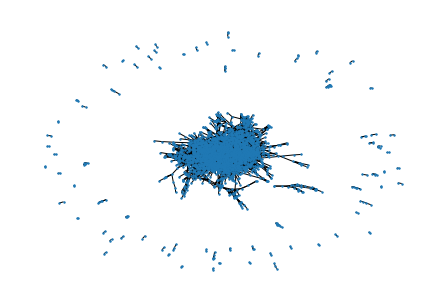

In [7]:
import matplotlib.pyplot as plt
data = dataset[0]
g = torch_geometric.utils.to_networkx(data, to_undirected=True)
nx.draw(g, node_size=2)
plt.show()

## 1. 简单图上的图嵌入

回顾一下图嵌入的通用框架：信息提取器、映射函数、重构器和优化目标
![](figures/framework.png)

### 1.1 DeepWalk

根据上面的通用框架，我们可按照如下思路实现DeepWalk，
```
    def deepwalk():
        # 利用随机游走提取共现信息
        # 映射函数，重构器、目标函数
      
```
另外，我们知道DeepWalk是基于Word2Vec模型实现的。Word2Vec本身就包含了映射函数、重构器和目标函数，那么借用已有的Word2Vec模型，我们可以用如下的思路来实现DeepWalk。
```
    def deepwalk(adj):
        # 利用随机游走提取共现信息
        walks = sample_random_walks(adj)
        # 映射函数、重构器、目标函数
        model = Word2Vec(walks)
        embedding = model()
        return embedding
```

在开始之前，我们需要安装gensim工具包，它提供了Word2Vec的实现。

`conda install gensim`

In [8]:
# 我们导入需要用到的工具包，如果出现ImportError麻烦大家自己安装一下对应的工具包
import numba
import numpy as np
import scipy.sparse as sp
from gensim.models import Word2Vec
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score

In [9]:
def deepwalk(adj, embedding_dim=64, walk_length=80, walks_per_node=10,
             num_neg_samples=1):
    """
    参数说明
    ----------
    adj : 图的邻接矩阵
    embedding_dim : 图嵌入的维度
    walks_per_node : 每个节点采样多少个随机游走
    walk_length : 随机游走的长度
    num_neg_samples : 负样本的数量
    """

    walks = sample_random_walks(adj, walk_length, walks_per_node) # 利用随机游走提取共现信息
    model = Word2Vec(walks, vector_size=embedding_dim, 
                     negative=num_neg_samples, compute_loss=True)  # 映射函数、重构器、目标
    embedding = model.wv.vectors[np.fromiter(map(int, model.wv.index_to_key), np.int32).argsort()] # 从词向量中取出节点嵌入
    return embedding

In [10]:
def sample_random_walks(adj, walk_length, walks_per_node):
    """对图中每个节点采样随机游走"""
    adj = sp.csr_matrix(adj)
    random_walks = _random_walk(adj.indptr,
                                adj.indices,
                                walk_length,
                                walks_per_node).reshape([-1, walk_length])
    random_walks = [list(map(str, walk)) for walk in random_walks] # 把格式转换成str，方便word2vec进行处理
    return random_walks

# numba可以对Python程序进行加速（通过并行）。所以当我们的程序中有多重循环就可以考虑使用numba来加速。
# 将下面这行代码放在我们想要并行的函数上面。注意numba只能加速针对numpy数组的操作。
@numba.jit(nopython=True) 
def _random_walk(indptr, indices, walk_length, walks_per_node):
    """并行地对图中每个节点采样随机游走"""
    N = len(indptr) - 1 # 得到节点数量
    walks = []

    for ir in range(walks_per_node):
        for n in range(N):
            for il in range(walk_length):
                walks.append(n)
                n = np.random.choice(indices[indptr[n]:indptr[n + 1]]) # 从节点n的邻居中随机采样一个节点作为新的节点

    return np.array(walks)

* 其中`indices[indptr[n]:indptr[n+1]]` 表示的是第n行的所有非零元素的位置

我们已经完成了deepwalk生成图嵌入的部分，下面让我们具体展示deepwalk的使用。

这里我们继续以Cora数据集为例：

In [11]:
from torch_geometric.datasets import Planetoid
dataset = Planetoid(root='./data', name='Cora') # 将数据保存在data文件夹下
data = dataset[0]
adj = torch_geometric.utils.to_scipy_sparse_matrix(data.edge_index)

In [12]:
embedding = deepwalk(adj, embedding_dim=64)
embedding.shape

(2708, 64)

In [13]:
len(sp.csr_matrix(adj).indices)

10556

In [14]:
# 为衡量生成的图嵌入的质量，我们可以训练一个线性模型（比如逻辑回归模型）来预测节点的标签
def evaluate_node_classification(embedding_matrix, labels, train_mask, 
                                 test_mask, normalize_embedding=True, max_iter=1000):

    if normalize_embedding:
        embedding_matrix = normalize(embedding_matrix)

    features_train = embedding_matrix[train_mask]
    features_test = embedding_matrix[test_mask]
    labels_train = labels[train_mask]
    labels_test = labels[test_mask]


    clf = LogisticRegression(solver='lbfgs', max_iter=max_iter, multi_class='auto')
    clf.fit(features_train, labels_train)

    preds = clf.predict(features_test)
    test_acc = accuracy_score(labels_test, preds)
    return preds, test_acc

In [15]:
preds, test_acc = evaluate_node_classification(embedding, data.y, data.train_mask, data.test_mask)
print('Test Acc: %.4f' % test_acc)

Test Acc: 0.6740


我们可以通过调节`deepwalk()`中的超参数，以及`evaluate_node_classification()`中逻辑回归模型的超参数来进一步提高模型准确率。

下面我们对学到的图嵌入进行可视化。常用的可视化方法是TSNE，可以将高维数据以二维坐标点的形式呈现出来。通常来说，我们可以使sklearn提供的TSNE模型`sklearn.manifold.TSNE`来实现，但是它可能会jupyter notebook中断。所以这里我们采用另外一个工具包`bhtsne`中的TSNE模型来实现我们的可视化。首先安装bhtsne：

In [16]:
!pip install bhtsne

     |████████████████████████████████| 86 kB 3.4 MB/s 
  Created wheel for bhtsne: filename=bhtsne-0.1.9-cp37-cp37m-linux_x86_64.whl size=214567 sha256=8d36c573d1ae2b7e22d184a0d1170acee15484febbbf1193c9d3739cdb98bb9d
  Stored in directory: /root/.cache/pip/wheels/e4/4c/71/26b7b0736d179d6bfe9d753629955515bf7ba7c1c8a8d98cb4
Successfully built bhtsne


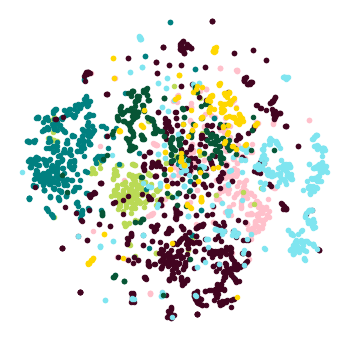

In [17]:
from bhtsne import tsne
def plot_points(colors, embedding):
    z = tsne(embedding.astype('float64'))
    y = data.y.numpy()

    plt.figure(figsize=(6, 6))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors, embedding)

### 1.2 PyG中的DeepWalk和Node2Vec

上一个小节里我们讲解了基于`gensim.models.Word2Vec`的DeepWalk实现。这个小节我们将会讲解PyG里实现DeepWalk和Node2Vec的方法。值得注意的是，DeepWalk可以看作是参数p和参数q为1的Node2Vec模型。

在PyG的实现中，我们将会很清楚地看到图嵌入通用框架的四个部分的构建：信息提取器、映射函数、重构器和优化目标。

具体地，信息提取器就是提取随机游走，映射函数就是一层Embedding Layer，重构器和优化目标即是由节点嵌入的内积构成的函数。

下面这部分代码来自PyG中的[node2vec.py](https://github.com/rusty1s/pytorch_geometric/blob/74245f3a680c1f6fd1944623e47d9e677b43e827/torch_geometric/nn/models/node2vec.py)，这里做了一点小修改来让它更简洁。

In [18]:
import torch
from torch.nn import Embedding
from torch.utils.data import DataLoader
from torch_sparse import SparseTensor
import torch_cluster
random_walk = torch.ops.torch_cluster.random_walk

class Node2Vec(torch.nn.Module):
    
    ################### PART 1 ###################
    def __init__(self, edge_index, embedding_dim, walk_length, context_size,
                 walks_per_node=1, p=1, q=1, num_negative_samples=1,
                 num_nodes=None, sparse=False):
        super(Node2Vec, self).__init__()

        N = edge_index.max().item() + 1 # 节点数量
        row, col = edge_index
        self.adj = SparseTensor(row=row, col=col, sparse_sizes=(N, N))
        self.adj = self.adj.to('cpu')

        assert walk_length >= context_size

        # 一些基本的超参数
        self.embedding_dim = embedding_dim
        self.walk_length = walk_length - 1
        self.context_size = context_size
        self.walks_per_node = walks_per_node
        self.p = p
        self.q = q
        self.num_negative_samples = num_negative_samples
        
        
        # 初始化映射函数里的参数
        self.embedding = Embedding(N, embedding_dim, sparse=sparse)
        self.embedding.reset_parameters()

    def forward(self, batch=None):
        """Returns the embeddings for the nodes in :obj:`batch`."""
        emb = self.embedding.weight
        return emb if batch is None else emb[batch]
    
    
    ################### PART 2 ###################
    def loader(self, **kwargs):
        return DataLoader(range(self.adj.sparse_size(0)),
                          collate_fn=self.sample, **kwargs)

    def sample(self, batch):
        # batch其实就是一组节点
        if not isinstance(batch, torch.Tensor):
            batch = torch.tensor(batch)
        return self.pos_sample(batch), self.neg_sample(batch)
    
    def pos_sample(self, batch):
        """采样正样本"""
        batch = batch.repeat(self.walks_per_node)
        rowptr, col, _ = self.adj.csr()
        rw = random_walk(rowptr, col, batch, self.walk_length, self.p, self.q) # 采样随机游走
        if not isinstance(rw, torch.Tensor):
            rw = rw[0]
        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size # 计算需要迭代的次数
        for j in range(num_walks_per_rw): 
            walks.append(rw[:, j:j + self.context_size]) # 用窗口(context_size)来划分前面得到的随机游走
        return torch.cat(walks, dim=0)

    def neg_sample(self, batch):
        """采样负样本"""
        batch = batch.repeat(self.walks_per_node * self.num_negative_samples)

        rw = torch.randint(self.adj.sparse_size(0),
                           (batch.size(0), self.walk_length))  # 直接随机采样图中节点序列作为负样本
        rw = torch.cat([batch.view(-1, 1), rw], dim=-1)

        walks = []
        num_walks_per_rw = 1 + self.walk_length + 1 - self.context_size # 计算需要迭代的次数
        for j in range(num_walks_per_rw):
            walks.append(rw[:, j:j + self.context_size])
        return torch.cat(walks, dim=0)
    
    
    ################### PART 3 ###################
    def loss(self, pos_rw, neg_rw):
        """根据正负样本计算损失函数"""
        EPS = 1e-15 # 出现在下面的地方，用于防止torch.log()中的输入为0
        
        # 正样本的损失函数
        start, rest = pos_rw[:, 0], pos_rw[:, 1:].contiguous()

        h_start = self.embedding(start).view(pos_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(pos_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1) # 计算内积
        pos_loss = -torch.log(torch.sigmoid(out) + EPS).mean()  # 希望start, reset的嵌入的内积大

        # 负样本的损失函数
        start, rest = neg_rw[:, 0], neg_rw[:, 1:].contiguous() 

        h_start = self.embedding(start).view(neg_rw.size(0), 1,
                                             self.embedding_dim)
        h_rest = self.embedding(rest.view(-1)).view(neg_rw.size(0), -1,
                                                    self.embedding_dim)

        out = (h_start * h_rest).sum(dim=-1).view(-1) # 计算内积
        neg_loss = -torch.log(1 - torch.sigmoid(out) + EPS).mean() # 希望start, reset的嵌入的内积小

        return pos_loss + neg_loss

In [19]:
# 训练Node2Vec模型
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [20]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    z = z.detach().cpu().numpy() # detach()将tensor从计算图中脱离出来，numpy()把tensor转换成numpy.array格式
    _, acc = evaluate_node_classification(z, data.y, data.train_mask, data.test_mask, max_iter=150)
    return acc

In [21]:
dataset = Planetoid(root='./data', name='Cora') # 将数据保存在data文件夹下
data = dataset[0]

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Node2Vec(data.edge_index, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)
loader = model.loader(batch_size=128, shuffle=True, num_workers=0) # 提取共现信息
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

for epoch in range(1, 10): # 这里使用更大的epoch将提高性能，比如100
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

Epoch: 01, Loss: 8.1217, Acc: 0.1660
Epoch: 02, Loss: 6.0510, Acc: 0.1930
Epoch: 03, Loss: 4.9454, Acc: 0.2200
Epoch: 04, Loss: 4.1213, Acc: 0.2630
Epoch: 05, Loss: 3.4692, Acc: 0.2870
Epoch: 06, Loss: 2.9489, Acc: 0.3290
Epoch: 07, Loss: 2.5401, Acc: 0.3720
Epoch: 08, Loss: 2.2094, Acc: 0.4110
Epoch: 09, Loss: 1.9458, Acc: 0.4430


## 2. 异质图上的图嵌入

DeepWalk和node2vec都是简单图上的图嵌入方法。近些年，针对于复杂图的图嵌入方法也不断涌现出来。这里我们以异质图为例来讲解其图嵌入方法。（异质图是复杂图中的研究主流。）

### 2.1. 异质图数据

In [23]:
import torch
from torch_geometric.datasets import AMiner
dataset = AMiner('data/AMiner')
data = dataset[0]

Extracting data/AMiner/net_aminer.zip
Extracting data/AMiner/raw/label.zip
Processing...
Done!


In [24]:
data

HeteroData(
  author={
    y=[246678],
    y_index=[246678],
    num_nodes=1693531
  },
  venue={
    y=[134],
    y_index=[134],
    num_nodes=3883
  },
  paper={ num_nodes=3194405 },
  (paper, written_by, author)={ edge_index=[2, 9323605] },
  (author, writes, paper)={ edge_index=[2, 9323605] },
  (paper, published_in, venue)={ edge_index=[2, 3194405] },
  (venue, publishes, paper)={ edge_index=[2, 3194405] }
)

不难看出，AMiner数据集中有三类节点，作者（author），会议（venue）和论文（paper）。

AMiner的原数据非常大，所以这里我们采样一部分子图来进行后面的实验。

值得注意的是，PyG在最近更新的2.0版本中提供了更多对于异质图的支持，包括对异质图的采样。详情可见https://pytorch-geometric.readthedocs.io/en/latest/notes/heterogeneous.html

In [25]:
def creat_mask(data):
    mask = torch.zeros(data['author'].num_nodes).bool()
    mask[data.y_index_dict['author']] = 1
    return mask
mask = creat_mask(data) # 创建一个mask，针对于所有author节点

In [26]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    num_neighbors=[10, 5, 5], # 采样节点/边的三阶邻居（）
    batch_size=500, # 用batch size 500来采样"author"类节点:
    input_nodes=('author', mask),
)

batch = next(iter(train_loader))

In [27]:
batch

HeteroData(
  author={
    y=[246678],
    y_index=[246678],
    num_nodes=4870,
    batch_size=500
  },
  venue={
    y=[134],
    y_index=[134],
    num_nodes=1035
  },
  paper={ num_nodes=26460 },
  (paper, written_by, author)={ edge_index=[2, 24379] },
  (author, writes, paper)={ edge_index=[2, 12225] },
  (paper, published_in, venue)={ edge_index=[2, 5175] },
  (venue, publishes, paper)={ edge_index=[2, 4701] }
)

In [28]:
subgraph = batch

In [29]:
subgraph.edge_index_dict

{('author',
  'writes',
  'paper'): tensor([[   0,  500,    0,  ..., 4867, 4868, 4869],
         [   0,    0,    1,  ..., 4700, 4700, 4700]]),
 ('paper',
  'published_in',
  'venue'): tensor([[21390, 21391, 21392,  ..., 26457, 26458, 26459],
         [    0,     0,     0,  ...,  1034,  1034,  1034]]),
 ('paper',
  'written_by',
  'author'): tensor([[    0,     1,     2,  ..., 21379, 21388, 21389],
         [    0,     0,     0,  ...,  4869,  4869,  4869]]),
 ('venue',
  'publishes',
  'paper'): tensor([[   0,    1,    0,  ...,  209,  209,  363],
         [   0,    1,    2,  ..., 4698, 4699, 4700]])}

### 2.2. MetaPath2Vec

MetaPath2Vec同样遵循我们前面提到的通用框架。这里我们不再细究其内部各个部分，而着重讲如何运用MetaPath2Vec。

In [30]:
from torch_geometric.nn import MetaPath2Vec

# 定义metapath
metapath = [
    ('author', 'writes', 'paper'),
    ('paper', 'published_in', 'venue'),
    ('venue', 'publishes', 'paper'),
    ('paper', 'written_by', 'author'),
]

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = MetaPath2Vec(subgraph.edge_index_dict, embedding_dim=128,
                     metapath=metapath, walk_length=50, context_size=7,
                     walks_per_node=5, num_negative_samples=5,
                     sparse=True).to(device)

## windows下只能使用单线程，需要修改num_workers=0
loader = model.loader(batch_size=128, shuffle=True, num_workers=0)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [32]:
def train():
    model.train()

    total_loss = 0
    for (pos_rw, neg_rw) in iter(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()


@torch.no_grad()
def test(train_ratio=0.9):
    model.eval()
    batch_size = subgraph['author'].batch_size
    z = model('author')[:batch_size]
    y = subgraph['author'].y[:batch_size]

    perm = torch.randperm(z.size(0))
    train_perm = perm[:int(z.size(0) * train_ratio)]
    test_perm = perm[int(z.size(0) * train_ratio):]

    return model.test(z[train_perm], y[train_perm], z[test_perm], y[test_perm],
                      max_iter=1000)

In [33]:
for epoch in range(1, 10):
    train()
    acc = test()
    print(f'Epoch: {epoch}, Accuracy: {acc:.4f}')

Epoch: 1, Accuracy: 0.2000
Epoch: 2, Accuracy: 0.1200
Epoch: 3, Accuracy: 0.1200
Epoch: 4, Accuracy: 0.2600
Epoch: 5, Accuracy: 0.1800
Epoch: 6, Accuracy: 0.2000
Epoch: 7, Accuracy: 0.1600
Epoch: 8, Accuracy: 0.1600
Epoch: 9, Accuracy: 0.1400


准确率其实不高，因为我们只使用了一小部分子图来做演示。感兴趣且有计算资源的同学可以考虑尝试用整个图来训练。

参考资料：

1.https://github.com/DSE-MSU/DeepRobust/blob/1ca69dd2c01cb15b733415240fdc1da151562225/deeprobust/graph/defense/node_embedding.py#L415
2.https://github.com/rusty1s/pytorch_geometric/blob/58eb6b433b4100544a20c05b5db4b8168a25d6c9/examples/metapath2vec.py